## Setup stuff

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
!pip install -r requirements.txt

In [26]:
!pip install nilearn

     --------------------------------------- 10.4/10.4 MB 59.5 MB/s eta 0:00:00
     ---------------------------------------- 3.9/3.9 MB 41.5 MB/s eta 0:00:00


In [1]:
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import numpy as np
import tensorflow as tf
import nibabel as nib
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from skimage.transform import resize

import argparse
import logging
import os
import random
import sys
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tensorboardX import SummaryWriter
from torch.nn.modules.loss import CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from utils import DiceLoss
from torchvision import transforms
from utils import test_single_volume

import zipfile
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from copy import deepcopy

from nilearn import plotting

import torch.nn.functional as F

In [2]:
class Encoding3D(nn.Module):
    def __init__(self, D, K, encoding):
        super(Encoding3D, self).__init__()
        self.D, self.K = D, K
        self.codewords = nn.Parameter(torch.Tensor(K, D), requires_grad=True)
        self.scale = nn.Parameter(torch.Tensor(K, D), requires_grad=True)
        self.reset_params()
        self.encoding = encoding

        self.fc = nn.Sequential(
            nn.Linear(D, D),
            nn.Sigmoid())

    def reset_params(self):
        std1 = 1./((self.K*self.D)**(1/2))
        self.codewords.data.uniform_(-std1, std1)
        self.scale.data.uniform_(-1, 0)

    def forward(self, X):
        assert(X.size(1) == self.D)
        B, D, T, H, W = X.size()
        N = T * H * W
        K = self.K

        # Flatten X to (B, N, D) for processing
        I = X.view(B, D, N).transpose(1, 2).contiguous()

        # Calculate assignment weights A (B, N, K, D)
        A = F.softmax(self.scale.view(1, 1, K, D) * (I.unsqueeze(2) - self.codewords.view(1, K, D)).pow(2), dim=2)

        if not self.encoding:  # Embedding
            E = (A * (I.unsqueeze(2) - self.codewords.view(1, K, D))).sum(1)
            E = E.mean(dim=1)
            gamma = self.fc(E)

            E = (A * (I.unsqueeze(2) - self.codewords.view(1, K, D))).sum(2)
            E = E.transpose(1, 2).contiguous().view(B, D, T, H, W)
            y = gamma.view(B, D, 1, 1, 1)
            E = F.relu_(E + E * y)
        else:  # Encoding
            E = (A * (I.unsqueeze(2) - self.codewords.view(1, K, D))).sum(1)

        return E

class EmbeddingModule3D(nn.Module):
    def __init__(self, in_channels, ncodes=24):
        super(EmbeddingModule3D, self).__init__()
        self.encoding = nn.Sequential(
            nn.Conv3d(in_channels, in_channels, 1, bias=False),
            nn.BatchNorm3d(in_channels),
            nn.ReLU(inplace=True),
            Encoding3D(D=in_channels, K=ncodes, encoding=False),
            nn.BatchNorm3d(in_channels),
            nn.ReLU(inplace=True))
        self.conv = nn.Sequential(
            nn.Conv3d(2 * in_channels, in_channels, 1, bias=True),
            nn.BatchNorm3d(in_channels),
            nn.ReLU(inplace=True))

    def forward(self, x):
        encoded = self.encoding(x)
        output = self.conv(torch.cat((x, encoded), dim=1))
        return output

class ResBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock3D, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)

        self.downsample = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=1),
            nn.BatchNorm3d(out_channels)
        ) if in_channels != out_channels else None

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            residual = self.downsample(residual)
        out += residual
        out = self.relu(out)
        return out
    
class UNet3DWithKEM(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_n_filter=64):
        super(UNet3DWithKEM, self).__init__()

        self.enc1 = ResBlock3D(in_channels, base_n_filter)
        self.pool1 = nn.MaxPool3d(2)

        self.enc2 = ResBlock3D(base_n_filter, base_n_filter * 2)
        self.pool2 = nn.MaxPool3d(2)

        self.enc3 = ResBlock3D(base_n_filter * 2, base_n_filter * 4)
        self.pool3 = nn.MaxPool3d(2)

        # Bottleneck with KEM
        self.bottleneck = ResBlock3D(base_n_filter * 4, base_n_filter * 8)
        self.kem = EmbeddingModule3D(base_n_filter * 8)

        self.up3 = nn.ConvTranspose3d(base_n_filter * 8, base_n_filter * 4, kernel_size=2, stride=2)
        self.dec3 = ResBlock3D(base_n_filter * 8, base_n_filter * 4)

        self.up2 = nn.ConvTranspose3d(base_n_filter * 4, base_n_filter * 2, kernel_size=2, stride=2)
        self.dec2 = ResBlock3D(base_n_filter * 4, base_n_filter * 2)

        self.up1 = nn.ConvTranspose3d(base_n_filter * 2, base_n_filter, kernel_size=2, stride=2)
        self.dec1 = ResBlock3D(base_n_filter * 2, base_n_filter)

        self.final_conv = nn.Conv3d(base_n_filter, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        pool1 = self.pool1(enc1)

        enc2 = self.enc2(pool1)
        pool2 = self.pool2(enc2)

        enc3 = self.enc3(pool2)
        pool3 = self.pool3(enc3)

        bottleneck = self.bottleneck(pool3)
        kem_output = self.kem(bottleneck)

        up3 = self.up3(kem_output)
        dec3 = self.dec3(torch.cat((up3, enc3), dim=1))

        up2 = self.up2(dec3)
        dec2 = self.dec2(torch.cat((up2, enc2), dim=1))

        up1 = self.up1(dec2)
        dec1 = self.dec1(torch.cat((up1, enc1), dim=1))

        output = self.final_conv(dec1)
        return output

In [3]:
model = UNet3DWithKEM(base_n_filter=16)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")
if device.type == "cuda":
    print(torch.cuda.get_device_name(0))

model = nn.DataParallel(model)
model.to(device)

Using device cuda
NVIDIA GeForce RTX 3070 Ti Laptop GPU


DataParallel(
  (module): UNet3DWithKEM(
    (enc1): ResBlock3D(
      (conv1): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv3d(1, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
        (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (enc2): ResBlock3D(
      (conv1): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# CREATE A TORCH DATASET

from torch.utils.data import Dataset
import os
import nibabel as nib
import torch

class DeepLesion_dataset(Dataset):
    '''
    Assumes that labels are already unzipped
    '''
    def __init__(self, image_dir, label_dir, list_dir, split, clip=-1, transform=None):
        self.transform = transform
        self.split = split
        self.sample_list = [line.strip('\n') for line in open(os.path.join(list_dir, 'deeplesion_'+self.split+'.txt'))]
        self.image_dir = image_dir
        self.label_dir = label_dir

    def __len__(self):
        return len(self.sample_list)

    def __getitem__(self, idx):
        filename = self.sample_list[idx]
        image_path = os.path.join(self.image_dir, filename+'.nii.gz')
        label_path = os.path.join(self.label_dir, filename+'.nii.gz')
        
        image = nib.load(image_path).get_fdata()
        label = nib.load(label_path).get_fdata()
        
        # Include any extra preprocessing on image and label here
        image = image[np.newaxis, :, :, :]
        label = label[np.newaxis, :, :, :]
        print(image.shape, label.shape)
        
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)
        
        # Apply transformations
        if self.transform:
            # Apply the transformations to both images simultaneously:
            merged_images = torch.cat((image.unsqueeze(0), label.unsqueeze(0)), 0)
            transformed_images = self.transform(merged_images)
            # Get the transformed images:
            image = transformed_images[0]
            label = transformed_images[1]

        return image, label, case_name
    

image_dir = 'datasets/ULS23_Radboudumc_Bone/images'
label_dir = 'datasets/ULS23_Radboudumc_Bone/labels'
list_dir = 'datasets'
    
db_train = Bone_dataset(image_dir, label_dir, list_dir, 'train')
db_val = Bone_dataset(image_dir, label_dir, list_dir, 'val')
db_test = Bone_dataset(image_dir, label_dir, list_dir, 'test')

In [4]:
gz_file_path = '../ngkd_data/ULS23_deepLesion3D/images/000028_02_01_059_lesion_01.nii'
nifti_image = nib.load(gz_file_path)
image_array = nifti_image.get_fdata()
image_array = np.squeeze(image_array)
image_array = np.expand_dims(image_array, axis=(0, 1))
image_array = np.transpose(image_array, (0, 1, 4, 2, 3))
image_array.shape
image = torch.tensor(image_array, dtype=torch.float32)

outputs = model(image)
outputs.shape

In [6]:
gz_file_path = '../ngkd_data/ULS23_deepLesion3D/labels/000028_02_01_059_lesion_01.nii.gz'
nifti_image = nib.load(gz_file_path)
labels = nifti_image.get_fdata()
labels = np.squeeze(labels)
labels = labels.astype(int)
labels = np.expand_dims(labels, axis=(0))
labels = np.transpose(labels, (0, 3, 1, 2))
labels = torch.tensor(labels, dtype=torch.long)
labels = labels.to(device)
labels.shape

torch.Size([1, 128, 256, 256])

In [7]:
def dice_loss(preds, labels):
    """
    Compute the Dice loss between predictions and labels.
    preds: Tensor of shape (batch_size, 1, 128, 256, 256)
    labels: Tensor of shape (batch_size, 128, 256, 256)
    """
    # Ensure the predictions are in [0,1] by applying sigmoid
    preds = torch.sigmoid(preds)
    
    # Remove the channel dimension from preds to match labels' shape
    preds = preds.squeeze(1)
    
    # Calculate intersection and union
    intersection = (preds * labels).sum(dim=(1, 2, 3))
    union = preds.sum(dim=(1, 2, 3)) + labels.sum(dim=(1, 2, 3))
    
    # Compute Dice coefficient and Dice loss
    dice_coeff = (2. * intersection + 1e-6) / (union + 1e-6)  # Adding a small epsilon to avoid division by zero
    dice_loss = 1 - dice_coeff
    
    # Return the average Dice loss over the batch
    return dice_loss.mean()

loss = dice_loss(outputs, labels)
loss

tensor(0.9999, device='cuda:0', grad_fn=<MeanBackward0>)

In [8]:
loss.backward()

In [9]:
# train_dir = 'datasets/preprocessed/train'

# class NiftiDataset(Dataset):
#     def __init__(self, slices_dir, clip=-1, transform=None):
#         self.slices_dir = slices_dir
#         self.transform = transform
#         self.filenames = [f for f in os.listdir(slices_dir) if f.endswith(".npz")]
#         if clip > 0:
#             self.filenames = self.filenames[:clip]

#     def __len__(self):
#         return len(self.filenames)

#     def __getitem__(self, idx):
#         slice_path = os.path.join(self.slices_dir, self.filenames[idx])

#         # Load image
#         data = np.load(slice_path)
#         image, label = data["image"], data["label"]
#         image = torch.tensor(image, dtype=torch.float32)
#         label = torch.tensor(label, dtype=torch.long)

#         # Apply transformations
#         if self.transform:
#             # Apply the transformations to both images simultaneously:
#             merged_images = torch.cat((image.unsqueeze(0), label.unsqueeze(0)), 0)
#             transformed_images = self.transform(merged_images)
#             # Get the transformed images:
#             image = transformed_images[0]
#             label = transformed_images[1]

#         sample = {"image": image, "label": label}
#         if self.transform:
#             sample = self.transform(sample)
#         sample["case_name"] = self.filenames[idx].strip("\n")
#         return sample
    
# db_train = NiftiDataset(train_dir)
# trainloader = DataLoader(db_train, batch_size=1, shuffle=False)
# _, sampled_batch = next(enumerate(trainloader))
# image_batch, label_batch = sampled_batch["image"], sampled_batch["label"]
# image_batch, label_batch = image_batch.to(device), label_batch.to(device)
# print(image_batch.shape, label_batch.shape)

torch.Size([1, 1, 224, 224]) torch.Size([1, 1, 224, 224])


# Visualizations

In [22]:
import nibabel as nib
from nilearn import plotting
import gzip
import zipfile
import io
import matplotlib.pyplot as plt
import matplotlib.colors
from skimage.transform import rotate
import numpy as np

# Specify path to .nii.gz imaging data
gz_file_path = '../ngkd_data/ULS23_deepLesion3D/images/000028_02_01_059_lesion_01.nii'
gz_file_path_2 = '../ngkd_data/ULS23_deepLesion3D/images/000332_06_02_264_lesion_01.nii'
nifti_image = nib.load(gz_file_path)
image_array = nifti_image.get_fdata()
nifti_image_2 = nib.load(gz_file_path_2)
image_array_2 = nifti_image_2.get_fdata()

In [23]:
image_array = np.squeeze(image_array)
image_array_2 = np.squeeze(image_array_2)
image_array.shape

(256, 256, 128)

In [24]:
slice_number = 64
rotated_slice = np.rot90(image_array[:, :, slice_number])
rotated_slice_2 = np.rot90(image_array_2[:, :, slice_number])
rotated_slice.shape

(256, 256)

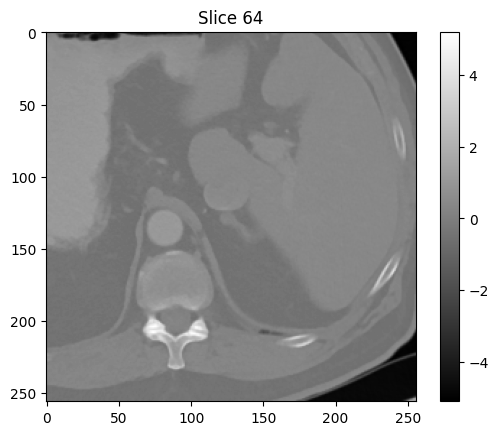

In [25]:
def normalize(image):
    mean = np.mean(image)
    std = np.std(image)
    normalized_image = (image - mean) / std
    return normalized_image

norm_slice = normalize(rotated_slice)
plt.imshow(norm_slice, cmap='gray')
plt.title(f'Slice {slice_number}')
plt.colorbar()
plt.show()

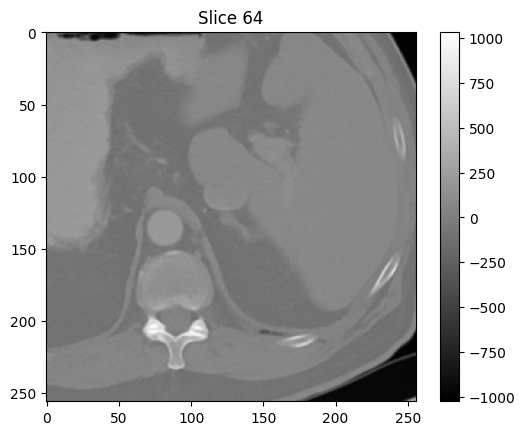

In [17]:
plt.imshow(rotated_slice, cmap='gray')
plt.title(f'Slice {slice_number}')
plt.colorbar()
plt.show()

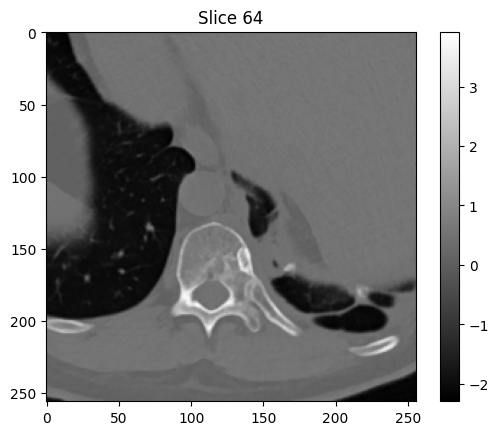

In [26]:
norm_slice_2 = normalize(rotated_slice_2)
plt.imshow(norm_slice_2, cmap='gray')
plt.title(f'Slice {slice_number}')
plt.colorbar()
plt.show()

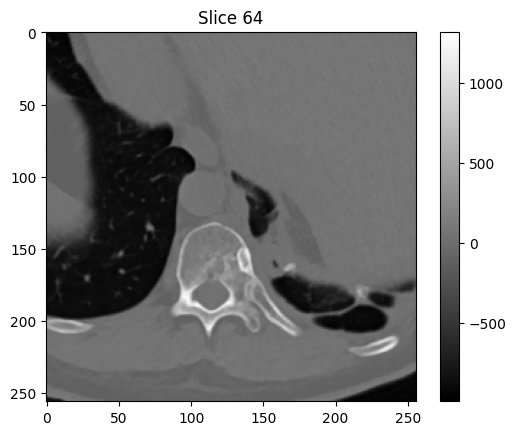

In [13]:
# Visualize a single image slice (adjust the slice number as needed)
plt.imshow(rotated_slice, cmap='gray')
plt.title(f'Slice {slice_number}')
plt.colorbar()
plt.show()

# # Image 3D visualization using nilearn
# plotting.plot_anat(nifti_image)
# plt.show()

In [29]:
print(f"1: {np.min(rotated_slice)}, {np.max(rotated_slice)}, {np.mean(rotated_slice)}, {np.std(rotated_slice)}")
print(f"2: {np.min(rotated_slice_2)}, {np.max(rotated_slice_2)}, {np.mean(rotated_slice_2)}, {np.std(rotated_slice_2)}")

1: -1024.0, 1035.0, -4.9000244140625, 199.56312319454102
2: -992.0, 1320.0, -138.94908142089844, 371.81305769992844


In [3]:
import nibabel as nib

# Replace 'your_image.nii' with the path to your NIfTI file
nii_file_path = '../ngkd_data/ULS23_deepLesion3D/images/000028_02_01_059_lesion_01.nii'

# Load the NIfTI file
nii_image = nib.load(nii_file_path)

# Get the header of the NIfTI file
header = nii_image.header

print(header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  4 256 256 128   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.       0.976562 0.976562 5.       1.       1.       1.       1.      ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 179.68741
qoffset_y       : 123.046814
qoffset_z       

# Prepare Data

In [3]:
# CREATE TRAIN/VAL/TEST LISTS TO STORE WHICH VOIS GO WHERE

import os
import random

image_dir = 'datasets/ULS23_Radboudumc_Bone/images'
output_dir = 'datasets'

filenames = [image_filename[:-7] for image_filename in os.listdir(image_dir)]
random.seed(123)

def split_list(data, train_prop=0.6, val_prop=0.2, test_prop=0.2):
    if train_prop + val_prop + test_prop != 1:
        raise ValueError("The proportions must sum up to 1.")
    
    random.shuffle(data)
    
    # Calculate split indices
    total_len = len(data)
    train_end = int(total_len * train_prop)
    val_end = train_end + int(total_len * val_prop)
    
    # Split the data
    train_data = data[:train_end]
    val_data = data[train_end:val_end]
    test_data = data[val_end:]
    
    return train_data, val_data, test_data

train_data, val_data, test_data = split_list(filenames)

def save_list(data, output_dir, filename):
    file_path = os.path.join(output_dir, filename)
    with open(file_path, 'w') as file:
        for item in data:
            file.write(f"{item}\n")
            
save_list(train_data, output_dir, "bone_train.txt")
save_list(val_data, output_dir, "bone_val.txt")
save_list(test_data, output_dir, "bone_test.txt")

In [4]:
# UNZIP THE LABEL DATA

from tqdm import tqdm
import os
import zipfile

label_dir = 'datasets/ULS23_Radboudumc_Bone/labels'

# Loop through the image files
for filename in tqdm(os.listdir(label_dir)):
    if filename.endswith('.nii.gz.zip'):
        label_path = os.path.join(label_dir, filename)
        # Open the zip file
        with zipfile.ZipFile(label_path, 'r') as zip_ref:
            # Extract all the contents into the same directory
            zip_ref.extractall(label_dir)

print("Unzipping done.")

100%|████████████████████████████████████████████████████████████████████████| 1488/1488 [00:00<00:00, 1939.76it/s]

Unzipping done.


In [4]:
# CREATE A TORCH DATASET

from torch.utils.data import Dataset
import os
import nibabel as nib
import torch

class Bone_dataset(Dataset):
    '''
    Assumes that labels are already unzipped
    '''
    def __init__(self, image_dir, label_dir, list_dir, split, transform=None):
        self.transform = transform
        self.split = split
        self.sample_list = [line.strip('\n') for line in open(os.path.join(list_dir, 'bone_'+self.split+'.txt'))]
        self.image_dir = image_dir
        self.label_dir = label_dir

    def __len__(self):
        return len(self.sample_list)

    def __getitem__(self, idx):
        filename = self.sample_list[idx]
        image_path = os.path.join(self.image_dir, filename+'.nii.gz')
        label_path = os.path.join(self.label_dir, filename+'.nii.gz')
        
        image = nib.load(image_path).get_fdata()
        label = nib.load(label_path).get_fdata()
        
#         def process_volume(volume):
#             # Clip and normalize the volume
#             clipped_volume = np.clip(volume, -125, 275)
#             min_val, max_val = clipped_volume.min(), clipped_volume.max()
#             normalized_volume = (clipped_volume - min_val) / (max_val - min_val)
#             return normalized_volume
        
        # Include any extra preprocessing on image and label here
        
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        sample = {'image': image, 'label': label}
        if self.transform:
            sample = self.transform(sample)
        sample['case_name'] = self.sample_list[idx]
        return sample
    

image_dir = 'datasets/ULS23_Radboudumc_Bone/images'
label_dir = 'datasets/ULS23_Radboudumc_Bone/labels'
list_dir = 'datasets'
    
db_train = Bone_dataset(image_dir, label_dir, list_dir, 'train')
db_val = Bone_dataset(image_dir, label_dir, list_dir, 'val')
db_test = Bone_dataset(image_dir, label_dir, list_dir, 'test')

In [5]:
# CREATE A TORCH DATALOADER

from torch.utils.data import DataLoader

batch_size = 12

trainloader = DataLoader(db_train, batch_size=batch_size, shuffle=True)

# Test to see if loader is correct
# i_batch, sampled_batch = next(enumerate(trainloader))
# image_batch, label_batch = sampled_batch['image'], sampled_batch['label']
# print(i_batch)
# print(image_batch[0])
# print(label_batch[0])
# 
# Use like:
# for i_batch, sampled_batch in enumerate(trainloader):
#     image_batch, label_batch = sampled_batch['image'], sampled_batch['label']
#     image_batch, label_batch = image_batch.cuda(), label_batch.cuda()

#     outputs = model(image_batch)
#     ...

In [5]:
# Preprocess data for swin unet
# It expects 2d slices, not 3d volume
# Expect VOI files to be unzipped

def process_volume(volume):
    # Clip and normalize the volume
    clipped_volume = np.clip(volume, -125, 275)
    min_val, max_val = clipped_volume.min(), clipped_volume.max()
    normalized_volume = (clipped_volume - min_val) / (max_val - min_val)
    return normalized_volume

def crop_center(img, cropx, cropy):
    y, x, _ = img.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)    
    return img[starty:starty+cropy, startx:startx+cropx, :]

def process_and_save_slices(volume, label_volume, output_dir, base_filename):
    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    # Extract slices and save them
    for i in range(volume.shape[2]):  # Assuming the volume shape is (256, 256, 128)
        image_slice = volume[:, :, i]
        label_slice = label_volume[:, :, i]
        
        # Crop slices to 224
        image_slice = crop_center(image_slice, 224, 224)
        label_slice = crop_center(label_slice, 224, 224)
        
        # Reshape slices to (1, 224, 224)
        image_slice = np.transpose(image_slice, (2, 0, 1))
        label_slice = np.transpose(label_slice, (2, 0, 1))
        
        # Save as compressed .npz file
        slice_filename = os.path.join(output_dir, f'{base_filename}_slice_{i}.npz')
        np.savez_compressed(slice_filename, image=image_slice, label=label_slice)

def process_files(files, output_dir):
    # Loop through the training files
    for base_filename in tqdm(files):
        image_path = os.path.join(image_dir, base_filename + '.nii.gz')
        label_path = os.path.join(label_dir, base_filename + '.nii.gz')

        # Process image volume
        image_volume = nib.load(image_path).get_fdata()
        image_slices = process_volume(image_volume)

        # Process label volume
        label_volume = nib.load(label_path).get_fdata()
        label_slices = process_volume(label_volume)

        # Save slices
        process_and_save_slices(image_slices, label_slices, output_dir, base_filename)
        
image_dir = 'datasets/ULS23_Radboudumc_Bone/images'
label_dir = 'datasets/ULS23_Radboudumc_Bone/labels'
output_dir = 'datasets/preprocessed'
list_dir = 'datasets'

training_files = [line.strip('\n') for line in open(os.path.join(list_dir, 'bone_train.txt'))]
val_files = [line.strip('\n') for line in open(os.path.join(list_dir, 'bone_val.txt'))]

process_files(training_files, os.path.join(output_dir, 'train'))
process_files(val_files, os.path.join(output_dir, 'val'))

print("Preprocessing done.")

100%|████████████████████████████████████████████████████████████████████████████████| 148/148 [02:51<00:00,  1.16s/it]

Preprocessing done.


# Okay this is where the actual model setup starts

## Set model configs

In [2]:
from config import get_config

args = argparse.ArgumentParser()
args.cfg = "configs/swin_tiny_patch4_window7_224_lite.yaml"
args.batch_size = 12
args.cache_mode = 'no'

config = get_config(args)

=> merge config from configs/swin_tiny_patch4_window7_224_lite.yaml


## Dataloader

In [7]:
from torchvision.transforms.v2 import Compose, RandomHorizontalFlip, RandomVerticalFlip, RandomRotation

In [19]:
class NiftiDataset(Dataset):
    def __init__(self, slices_dir, clip=-1, transform=None):
        self.slices_dir = slices_dir
        self.transform = transform
        self.filenames = [f for f in os.listdir(slices_dir) if f.endswith(".npz")]
        if clip > 0:
            self.filenames = self.filenames[:clip]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        slice_path = os.path.join(self.slices_dir, self.filenames[idx])

        # Load image
        data = np.load(slice_path)
        image, label = data["image"], data["label"]
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)
        
        # Apply transformations
        if self.transform:
            # Apply the transformations to both images simultaneously:
            merged_images = torch.cat((image.unsqueeze(0), target.unsqueeze(0)),0)
            transformed_images = self.transform(merged_images)
            # Get the transformed images:
            image = transformed_images[0]
            label = transformed_images[1]

        sample = {"image": image, "label": label}
        if self.transform:
            sample = self.transform(sample)
        sample["case_name"] = self.filenames[idx].strip("\n")
        return sample

In [18]:
# # Create two fake images (identical for test purposes):
# image = torch.randn((1, 224, 224))
# target = image.clone()

# transforms = Compose([
#                 RandomHorizontalFlip(),
#                 RandomVerticalFlip(),
#                 RandomRotation(degrees=10)  # You can adjust the degree of rotation
#             ])

# # This is the trick (concatenate the images):
# both_images = torch.cat((image.unsqueeze(0), target.unsqueeze(0)),0)

# # Apply the transformations to both images simultaneously:
# transformed_images = transforms(both_images)

# # Get the transformed images:
# image_trans = transformed_images[0]
# target_trans = transformed_images[1]

# # Compare the transformed images:
# torch.all(image_trans == target_trans).item()

True

In [21]:
train_dir = 'datasets/preprocessed/train'
val_dir = 'datasets/preprocessed/val'

transforms = Compose([
                RandomHorizontalFlip(),
                RandomVerticalFlip(),
                RandomRotation(degrees=10)  # You can adjust the degree of rotation
            ])

db_train = NiftiDataset(train_dir, transform=transforms)
db_val = NiftiDataset(val_dir, transform=transforms)
print("The length of train set is: {}".format(len(db_train)))
print("The length of val set is: {}".format(len(db_val)))

trainloader  = DataLoader(db_train, batch_size=args.batch_size, shuffle=True)
valloader  = DataLoader(db_val, batch_size=args.batch_size, shuffle=True)

i_batch, sampled_batch = next(enumerate(trainloader))
print(sampled_batch['image'].shape)

The length of train set is: 57088
The length of val set is: 18944
Shape is: torch.Size([1, 224, 224])
Shape is: torch.Size([1, 224, 224])
Shape is: torch.Size([1, 224, 224])
Shape is: torch.Size([1, 224, 224])
Shape is: torch.Size([1, 224, 224])
Shape is: torch.Size([1, 224, 224])
Shape is: torch.Size([1, 224, 224])
Shape is: torch.Size([1, 224, 224])
Shape is: torch.Size([1, 224, 224])
Shape is: torch.Size([1, 224, 224])
Shape is: torch.Size([1, 224, 224])
Shape is: torch.Size([1, 224, 224])
torch.Size([12, 1, 224, 224])


## Swinunet model

In [4]:
from networks.vision_transformer import SwinUnet

model = SwinUnet(config, img_size=224, num_classes=2)
model.load_from(config)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model= nn.DataParallel(model)
model.to(device)

C:\Users\Jovian\anaconda3\envs\python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.2;num_classes:2
---final upsample expand_first---


C:\Users\Jovian\anaconda3\envs\python38\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


pretrained_path:./pretrained_ckpt/swin_tiny_patch4_window7_224.pth
---start load pretrained modle of swin encoder---


DataParallel(
  (module): SwinUnet(
    (swin_unet): SwinTransformerSys(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (layers): ModuleList(
        (0): BasicLayer(
          dim=96, input_resolution=(56, 56), depth=2
          (blocks): ModuleList(
            (0): SwinTransformerBlock(
              dim=96, input_resolution=(56, 56), num_heads=3, window_size=7, shift_size=0, mlp_ratio=4.0
              (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attn): WindowAttention(
                dim=96, window_size=(7, 7), num_heads=3
                (qkv): Linear(in_features=96, out_features=288, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=96, out_features=96, bias=True)
                (proj_drop): Dropout(p=0.0

In [25]:
model.train()

DataParallel(
  (module): SwinUnet(
    (swin_unet): SwinTransformerSys(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (layers): ModuleList(
        (0): BasicLayer(
          dim=96, input_resolution=(56, 56), depth=2
          (blocks): ModuleList(
            (0): SwinTransformerBlock(
              dim=96, input_resolution=(56, 56), num_heads=3, window_size=7, shift_size=0, mlp_ratio=4.0
              (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attn): WindowAttention(
                dim=96, window_size=(7, 7), num_heads=3
                (qkv): Linear(in_features=96, out_features=288, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=96, out_features=96, bias=True)
                (proj_drop): Dropout(p=0.0

In [26]:
ce_loss = CrossEntropyLoss()
dice_loss = DiceLoss(2)
base_lr = 0.05
optimizer = optim.SGD(model.parameters(), lr=base_lr, momentum=0.9, weight_decay=0.0001)

In [27]:
iter_num = 0
max_epoch = 500
max_iterations = max_epoch * len(trainloader)

In [28]:
best_performance = 0.0
snapshot_path = 'snapshots'

In [29]:
overall_start = timer()
history = []

# Initialize early stopping variables
best_val_metric = float('inf')
patience = 10
wait = 0
best_model = None

# For each epoch
iterator = tqdm(range(max_epoch), ncols=100)
for epoch_num in iterator:
    start = timer()
    history_ce = 0.0
    history_dice = 0.0
    history_loss = 0.0
    
    # Training loop
    for i_batch, sampled_batch in enumerate(trainloader):
        image_batch, label_batch = sampled_batch['image'], sampled_batch['label']
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        
        outputs = model(image_batch)
        
        loss_ce = ce_loss(outputs, label_batch.squeeze(1).long())
        loss_dice = dice_loss(outputs, label_batch.squeeze(1), softmax=True)
        loss = 0.4 * loss_ce + 0.6 * loss_dice
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_ = base_lr * (1.0 - iter_num / max_iterations) ** 0.9
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr_

        history_ce += loss_ce.item()
        history_dice += loss_dice.item()
        history_loss += loss.item()
        iter_num += 1
        # Track training progress
        print(
            f'Epoch: {epoch_num}\t{100 * (i_batch + 1) / len(trainloader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
            end='\r')   
    
    # Validation loop
    print('Checking validation loss...')
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # No need to track gradients during validation
        for i_batch, sampled_batch in enumerate(valloader):
            image_batch, label_batch = sampled_batch['image'], sampled_batch['label']
            image_batch, label_batch = image_batch.to(device), label_batch.to(device)

            outputs = model(image_batch)

            loss_dice = dice_loss(outputs, label_batch.squeeze(1), softmax=True)
            
            val_loss += loss_dice.item()

    val_loss /= len(valloader)
    history_ce /= len(trainloader)
    history_dice /= len(trainloader)
    history_loss /= len(trainloader)
    history.append([history_ce, history_dice, history_loss, val_loss])     
    
    # Early Stopping Check
    if val_loss < best_val_metric:
        best_val_metric = val_loss
        best_model = deepcopy(model.state_dict())  # Save a copy of the current best model
        wait = 0  # Reset wait counter
        print(f"Validation loss improved to {val_loss:.4f}. Saving model...")
    else:
        wait += 1
        print(f"Validation loss did not improve. ({wait}/{patience})")

    if wait >= patience:
        print("Stopping early due to lack of improvement in validation loss.")
        # Save
        save_history_path = os.path.join(snapshot_path, 'epoch_' + str(epoch_num) + '_history.npz')
        np.savez_compressed(save_history_path, history=history)
        save_model_path = os.path.join(snapshot_path, 'epoch_' + str(epoch_num) + '.pth')
        torch.save(model.state_dict(), save_model_path)
        print(f"Saved model to {save_model_path}")
        break
        
    # Save occasionally
    if epoch_num+1 % 50 == 0:
        save_history_path = os.path.join(snapshot_path, 'epoch_' + str(epoch_num) + '_history.npz')
        np.savez_compressed(save_history_path, history=history)
        save_model_path = os.path.join(snapshot_path, 'epoch_' + str(epoch_num) + '.pth')
        torch.save(model.state_dict(), save_model_path)
        print(f"Saved model to {save_model_path}")
iterator.close()

total_time = timer() - overall_start
print(f'{total_time:.2f} total seconds elapsed. {total_time / (max_epoch+1):.2f} seconds per epoch.')

  0%|▏                                                              | 1/500 [00:00<04:20,  1.92it/s]

Checking validation loss...
Validation loss improved to 0.5215. Saving model...


  0%|▎                                                              | 2/500 [00:00<02:54,  2.85it/s]

Checking validation loss...
Validation loss improved to 0.5020. Saving model...


  1%|▍                                                              | 3/500 [00:00<02:26,  3.38it/s]

Checking validation loss...
Validation loss improved to 0.5002. Saving model...


  1%|▌                                                              | 4/500 [00:01<02:16,  3.65it/s]

Checking validation loss...
Validation loss improved to 0.5000. Saving model...


  1%|▋                                                              | 5/500 [00:01<02:08,  3.87it/s]

Checking validation loss...
Validation loss improved to 0.5000. Saving model...


  1%|▊                                                              | 6/500 [00:01<02:03,  4.00it/s]

Checking validation loss...
Validation loss improved to 0.5000. Saving model...


  1%|▉                                                              | 7/500 [00:01<02:00,  4.10it/s]

Checking validation loss...
Validation loss improved to 0.5000. Saving model...


  2%|█                                                              | 8/500 [00:02<02:03,  3.99it/s]

Checking validation loss...
Validation loss improved to 0.5000. Saving model...


  2%|█▏                                                             | 9/500 [00:02<02:06,  3.89it/s]

Checking validation loss...
Validation loss improved to 0.5000. Saving model...


  2%|█▏                                                            | 10/500 [00:02<02:08,  3.82it/s]

Checking validation loss...
Validation loss improved to 0.5000. Saving model...


  2%|█▎                                                            | 11/500 [00:02<02:07,  3.82it/s]

Checking validation loss...
Validation loss improved to 0.4999. Saving model...


  2%|█▍                                                            | 12/500 [00:03<02:05,  3.88it/s]

Checking validation loss...
Validation loss improved to 0.4999. Saving model...


  3%|█▌                                                            | 13/500 [00:03<02:03,  3.94it/s]

Checking validation loss...
Validation loss improved to 0.4998. Saving model...


  3%|█▋                                                            | 14/500 [00:03<02:04,  3.91it/s]

Checking validation loss...
Validation loss improved to 0.4998. Saving model...


  3%|█▊                                                            | 15/500 [00:04<02:06,  3.84it/s]

Checking validation loss...
Validation loss improved to 0.4997. Saving model...


  3%|█▉                                                            | 16/500 [00:04<02:04,  3.88it/s]

Checking validation loss...
Validation loss improved to 0.4996. Saving model...


  3%|██                                                            | 17/500 [00:04<02:05,  3.84it/s]

Checking validation loss...
Validation loss improved to 0.4994. Saving model...


  4%|██▏                                                           | 18/500 [00:04<02:14,  3.60it/s]

Checking validation loss...
Validation loss improved to 0.4992. Saving model...


  4%|██▎                                                           | 19/500 [00:05<02:21,  3.41it/s]

Checking validation loss...
Validation loss improved to 0.4990. Saving model...


  4%|██▍                                                           | 20/500 [00:05<02:18,  3.46it/s]

Checking validation loss...
Validation loss improved to 0.4987. Saving model...


  4%|██▌                                                           | 21/500 [00:05<02:15,  3.54it/s]

Checking validation loss...
Validation loss improved to 0.4984. Saving model...


  4%|██▋                                                           | 22/500 [00:05<02:11,  3.64it/s]

Checking validation loss...
Validation loss improved to 0.4979. Saving model...


  5%|██▊                                                           | 23/500 [00:06<02:10,  3.67it/s]

Checking validation loss...
Validation loss improved to 0.4972. Saving model...


  5%|██▉                                                           | 24/500 [00:06<02:09,  3.68it/s]

Checking validation loss...
Validation loss improved to 0.4961. Saving model...


  5%|███                                                           | 25/500 [00:06<02:08,  3.69it/s]

Checking validation loss...
Validation loss improved to 0.4942. Saving model...


  5%|███▏                                                          | 26/500 [00:07<02:22,  3.32it/s]

Checking validation loss...
Validation loss improved to 0.4906. Saving model...


  5%|███▎                                                          | 27/500 [00:07<02:30,  3.15it/s]

Checking validation loss...
Validation loss improved to 0.4822. Saving model...


  6%|███▍                                                          | 28/500 [00:07<02:28,  3.19it/s]

Checking validation loss...
Validation loss improved to 0.4543. Saving model...


  6%|███▌                                                          | 29/500 [00:08<02:23,  3.29it/s]

Checking validation loss...
Validation loss improved to 0.3000. Saving model...


  6%|███▋                                                          | 30/500 [00:08<02:19,  3.36it/s]

Checking validation loss...
Validation loss improved to 0.0078. Saving model...


  6%|███▊                                                          | 31/500 [00:08<02:16,  3.45it/s]

Checking validation loss...
Validation loss improved to 0.0001. Saving model...


  6%|███▉                                                          | 32/500 [00:08<02:11,  3.56it/s]

Checking validation loss...
Validation loss improved to 0.0000. Saving model...


  7%|████                                                          | 33/500 [00:09<02:31,  3.08it/s]

Checking validation loss...
Validation loss improved to 0.0000. Saving model...


  7%|████▏                                                         | 34/500 [00:09<02:47,  2.78it/s]

Checking validation loss...
Validation loss improved to 0.0000. Saving model...


  7%|████▎                                                         | 35/500 [00:10<02:30,  3.10it/s]

Checking validation loss...
Validation loss did not improve. (1/10)


  7%|████▍                                                         | 36/500 [00:10<02:21,  3.27it/s]

Checking validation loss...
Validation loss did not improve. (2/10)


  7%|████▌                                                         | 37/500 [00:10<02:17,  3.36it/s]

Checking validation loss...
Validation loss did not improve. (3/10)


  8%|████▋                                                         | 38/500 [00:10<02:33,  3.02it/s]

Checking validation loss...
Validation loss did not improve. (4/10)


  8%|████▊                                                         | 39/500 [00:11<02:39,  2.89it/s]

Checking validation loss...
Validation loss did not improve. (5/10)


  8%|████▉                                                         | 40/500 [00:11<02:23,  3.21it/s]

Checking validation loss...
Validation loss did not improve. (6/10)


  8%|█████                                                         | 41/500 [00:11<02:17,  3.33it/s]

Checking validation loss...
Validation loss did not improve. (7/10)


  8%|█████▏                                                        | 42/500 [00:12<02:32,  3.00it/s]

Checking validation loss...
Validation loss did not improve. (8/10)


  9%|█████▎                                                        | 43/500 [00:12<02:41,  2.83it/s]

Checking validation loss...
Validation loss did not improve. (9/10)


  9%|█████▎                                                        | 43/500 [00:13<02:19,  3.28it/s]

Checking validation loss...
Validation loss did not improve. (10/10)
Stopping early due to lack of improvement in validation loss.
Saved model to snapshots\epoch_43.pth
13.11 total seconds elapsed. 0.03 seconds per epoch.


## Vizualizing histories

[[0.01527626 0.43734737 0.26851894 0.41914842]
 [0.01233749 0.40952195 0.25064818 0.41150175]
 [0.01203093 0.40397833 0.24719938 0.43035779]
 [0.01155231 0.39578362 0.24209111 0.41593844]
 [0.01128515 0.39080619 0.23899778 0.42614177]
 [0.01104153 0.38502428 0.23543119 0.41802406]
 [0.01079922 0.38125275 0.23307135 0.44100727]
 [0.01098986 0.3821518  0.23368703 0.42436305]
 [0.01066341 0.37801549 0.23107467 0.42637281]
 [0.01058957 0.37626393 0.22999419 0.42794739]
 [0.01048415 0.37542298 0.22944746 0.42279319]
 [0.01056752 0.37389247 0.2285625  0.41397365]]


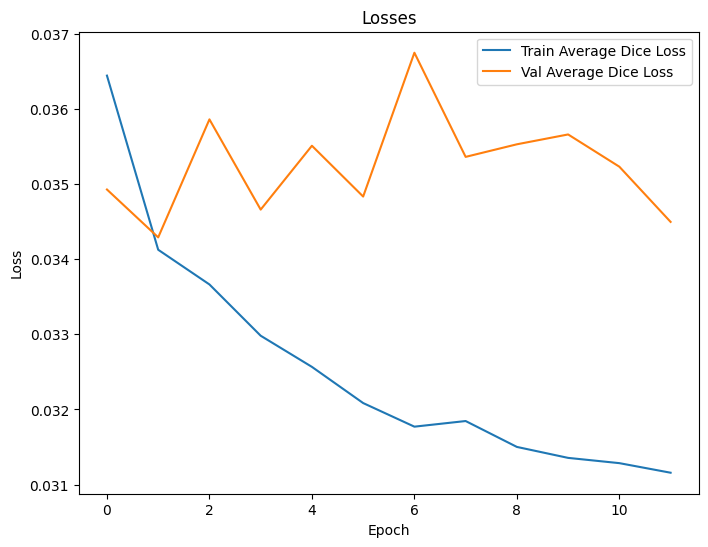

In [6]:
# history_path = os.path.join(snapshot_path, 'epoch_43_history.npz')
history_path = 'code/results/epoch_11_history.npz'
history = np.load(history_path)['history']
print(history)

history_np = np.array(history)

history_np /= 12

plt.figure(figsize=(8, 6))
# plt.plot(history_np[:, 0], label="Average Cross Entropy Loss")
plt.plot(history_np[:, 1], label="Train Average Dice Loss")
plt.plot(history_np[:, 3], label="Val Average Dice Loss")
# plt.plot(history_np[:, 2], label="Average Cross Entropy Loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses')
plt.show()

In [12]:
model = SwinUnet(config, img_size=224, num_classes=2).cuda()
model = nn.DataParallel(model)
model.load_state_dict(torch.load('code/results/epoch_11.pth'))

SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.2;num_classes:2
---final upsample expand_first---


<All keys matched successfully>

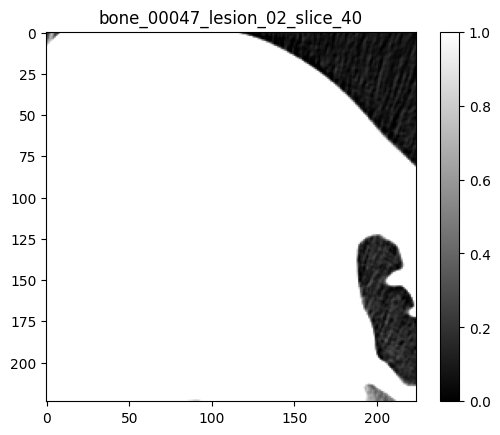

In [33]:
slice_number = 63

plt.imshow(db_val[slice_number]['image'].squeeze(), cmap='gray')
plt.title(db_val[slice_number]['case_name'][:-4])
plt.colorbar()
plt.show()



In [18]:
db_val[63]db

{'image': tensor([[[0.2000, 0.2109, 0.4036,  ..., 0.1273, 0.0764, 0.0218],
          [0.1891, 0.2691, 0.5055,  ..., 0.1055, 0.0364, 0.0109],
          [0.2364, 0.3527, 0.6545,  ..., 0.0655, 0.0145, 0.0255],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]]),
 'label': tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]),
 'case_name': 'bone_00047_lesion_02_slice_40.npz'}